In [4]:
import os
import torch
import pandas as pd
from skimage.io import imread
import numpy as np

from datetime import date

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn

from torchinfo import summary
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import classification_report

import json

import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Planet : Amazon space -- Full model running for multilabel classification


# 0) Initialization
## A) Getting Module and Functions

In [ ]:
from MultiModel_Amazon_Engine import *
from MultiModel_Amazon_Module import *

## B) Folder with images and labels csv

In [ ]:
data_folder = '../IPEO_Planet_project'
if not os.path.exists(data_folder):
    data_folder = input("Enter the data folder path: ")
    assert os.path.exists(data_folder), "I did not find the folder at, "+str(data_folder)

# 1) Creating model and transferring to device

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

In [ ]:
ground_model = GroundCNN().to(device)
cloud_model = CloudCNN().to(device)

In [ ]:
summary(ground_model, input_size=(48,3, 256, 256))

In [ ]:
summary(cloud_model, input_size=(48,3, 256, 256))

# 2) Loading the different datasets

In [ ]:
train_csv = 'training.csv'
validation_csv = 'validation.csv'
test_csv = 'test.csv'

In [ ]:
#Transform_choice = transforms.Compose([transforms.ToTensor(),transforms.CenterCrop(256), 
#                                       transforms.RandomAutocontrast(p=1), AdjustSaturation(1.2)])

Transform_choice = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(256),
                                       transforms.RandomHorizontalFlip(p=0.5), transforms.RandomVerticalFlip(p=0.5)])

#Transform_choice = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(256)])

In [ ]:
train_dataset = AmazonSpaceDual(csv_file=train_csv,
                                    root_dir=f'{data_folder}/train-jpg', transform=Transform_choice)
validation_dataset = AmazonSpaceDual(csv_file=validation_csv,
                                    root_dir=f'{data_folder}/train-jpg', transform=Transform_choice)
test_dataset = AmazonSpaceDual(csv_file=test_csv,
                                    root_dir=f'{data_folder}/train-jpg', transform=Transform_choice)

# 3) Wrapping into the different dataloaders

In [ ]:
batch_size = 24
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,  num_workers=6, shuffle=True, drop_last = True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=6, shuffle=True, drop_last = True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

## 4) Choice of Criterion and Opitimizer

In [ ]:
learning_rate = 0.001

ground_crit = nn.BCEWithLogitsLoss()
cloud_crit = nn.BCELoss()

#ground_optim = torch.optim.Adam(ground_model.parameters(), lr=learning_rate)
ground_optim = torch.optim.SGD(ground_model.parameters(), lr=learning_rate, momentum=0.9)
#cloud_optim = torch.optim.Adam(cloud_model.parameters(), lr=learning_rate)
cloud_optim = torch.optim.SGD(cloud_model.parameters(), lr=learning_rate, momentum=0.9)

# 5) TRAINING

## A) Training the cloud labels classifier

In [ ]:
%%time
epochs_number = 25

Cloud_results = train_solo("cloud_model",cloud_model, train_dataloader, validation_dataloader, device=device,optimizer=cloud_optim, lr = learning_rate, epochs=epochs_number, loss_fn=cloud_crit)

### A-i) Loading old results file (optional)

In [17]:
load_cloud_json = True

cloud_results_file = "Best_Models/CloudModel_training_results_20epochs_24batchsize_0.005lr_BCELoss()_crit_SGD_optim_2023-01-14.json"

if load_cloud_json:
    json_file = open(cloud_results_file)
    if json_file:
        print(f"Loading results from json file from {cloud_results_file}")
        Cloud_results = json.load(json_file)

Loading results from json file from Best_Models/CloudModel_training_results_20epochs_24batchsize_0.005lr_BCELoss()_crit_SGD_optim_2023-01-14.json


### A-ii) Visualisation of the training and validation metrics

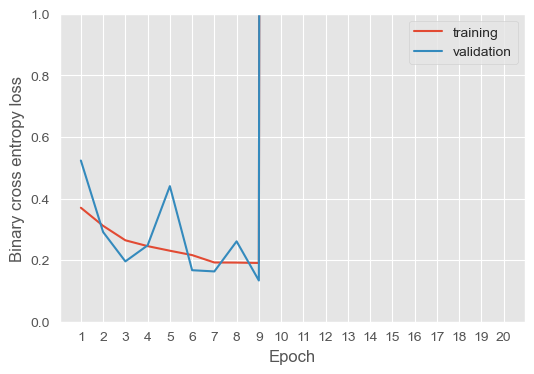

In [28]:
# Plot the loss evolution

plt.figure(figsize=(6,4))
x = range(1,len(Cloud_results['training']['total_loss'])+1)
plt.plot(x, np.array(Cloud_results['training']['total_loss']), label = 'training')
plt.plot(x, np.array(Cloud_results['validating']['total_loss']), label = 'validation')
#plt.title('Training: measured loss evolution')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel("Binary cross entropy loss")
plt.xticks(x)
#plt.savefig(f"LossEvolution_CloudModelTraining_{batch_size}batchsize_{str(learning_rate).replace('.','_')}lr_{cloud_crit}_{str(cloud_optim).split()[0]}_optim_{date.today()}.png")
plt.ylim([0,1])
plt.show()

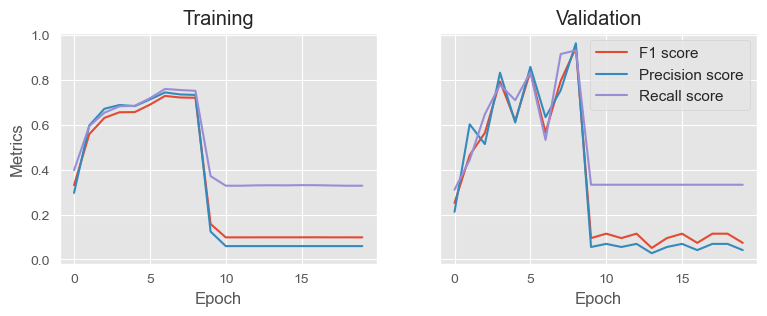

In [37]:
# Plot evolution of F1 score, precision and recall computed with macro averaging

fig, [ax1, ax2] = plt.subplots(1,2, figsize = (9,3), sharey=True)
ax1.plot(Cloud_results['training']['macro/f1'])
ax1.plot(Cloud_results['training']['macro/precision'])
ax1.plot(Cloud_results['training']['macro/recall'])
ax2.plot(Cloud_results['validating']['macro/f1'])
ax2.plot(Cloud_results['validating']['macro/precision'])
ax2.plot(Cloud_results['validating']['macro/recall'])
ax1.set_xlabel("Epoch")
ax2.set_xlabel("Epoch")
ax1.set_ylabel("Metrics")
ax1.set_title("Training")
ax2.set_title("Validation")
ax2.legend(['F1 score', 'Precision score', 'Recall score'], fontsize=11)
#plt.suptitle("Cloud label's model training\n")
#plt.savefig(f"Metrics_CloudModelTraining_{batch_size}batchsize_{str(learning_rate).replace('.','_')}lr_{cloud_crit}_{str(cloud_optim).split()[0]}_optim_{date.today()}.png")
plt.savefig(f"CloudModel_Training_Metrics_evolution.jpg")
plt.show()

### A-iii) Saving cloud model training results into a Json file

In [ ]:
# create json object from dictionary
js = json.dumps(Cloud_results)
# open file for writing, "w"
name = f"CloudModel_training_results_{epochs_number}epochs_{batch_size}batchsize_{learning_rate}lr_{cloud_crit}_crit_{str(cloud_optim).split()[0]}_optim_{date.today()}.json"
f = open(name, "a")

# write json object to file
f.write(js)
print(f"Saved the results (metrics) to: {name}")

# close file
f.close()

## B) Training the ground labels classifier

In [ ]:
epochs_number = 25

Ground_results = train_solo("ground_model",ground_model, train_dataloader, validation_dataloader, device=device,optimizer=ground_optim, lr = learning_rate, epochs=epochs_number, loss_fn=ground_crit)

### B-i) Loading old results file (optional)

In [2]:
load_ground_json = True

ground_results_file = "Best_Models/GroundModel_training_results_25epochs_24batchsize_0.01lr_BCEWithLogitsLoss()_crit_SGD_optim_2023-01-13.json"

if load_ground_json:
    json_file = open(ground_results_file)
    if json_file:
        print(f"Loading results from json file from {ground_results_file}")
        Ground_results = json.load(json_file)

Loading results from json file from Best_Models/GroundModel_training_results_25epochs_24batchsize_0.01lr_BCEWithLogitsLoss()_crit_SGD_optim_2023-01-13.json


### B-ii) Visualisation of the training and validation metrics

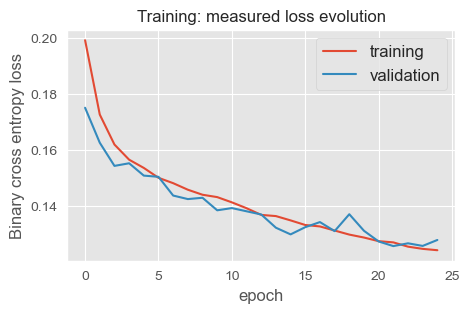

In [10]:
# Plot the loss evolution
plt.figure(figsize=(5,3))
plt.plot(np.array(Ground_results['training']['total_loss']), label = 'training')
plt.plot(np.array(Ground_results['validating']['total_loss']), label = 'validation')
plt.title('Measured loss evolution during training', fontsize=12)
plt.legend(fontsize=12)
plt.xlabel('epoch')
plt.ylabel("Binary cross entropy loss")
#plt.savefig(f"LossEvolution_GroundModelTraining_{batch_size}batchsize_{str(learning_rate).replace('.','_')}lr_{cloud_crit}_{str(cloud_optim).split()[0]}_optim_{date.today()}.png")
plt.savefig("GroundModel_Training_Loss.jpg")
plt.show()

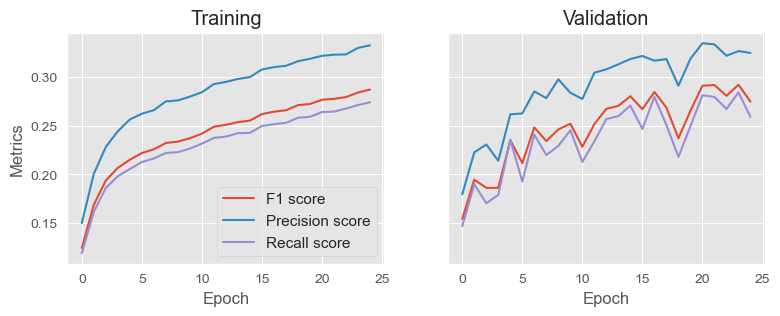

In [36]:
# Plot evolution of F1 score, precision and recall computed with macro averaging
fig, [ax1, ax2] = plt.subplots(1,2, figsize = (9,3), sharey=True)
ax1.plot(Ground_results['training']['macro/f1'])
ax1.plot(Ground_results['training']['macro/precision'])
ax1.plot(Ground_results['training']['macro/recall'])
ax2.plot(Ground_results['validating']['macro/f1'])
ax2.plot(Ground_results['validating']['macro/precision'])
ax2.plot(Ground_results['validating']['macro/recall'])
ax1.set_xlabel("Epoch")
ax2.set_xlabel("Epoch")
ax1.set_ylabel("Metrics")
ax1.set_title("Training")
ax2.set_title("Validation")
ax1.legend(['F1 score', 'Precision score', 'Recall score'], fontsize=11)
#plt.suptitle("Ground label's model training\n")
#plt.savefig(f"Metrics_GroundModelTraining_{batch_size}batchsize_{str(learning_rate).replace('.','_')}lr_{cloud_crit}_{str(cloud_optim).split()[0]}_optim_{date.today()}.png")
plt.savefig(f"GroundModel_Training_Metrics_evolution.jpg")
plt.show()

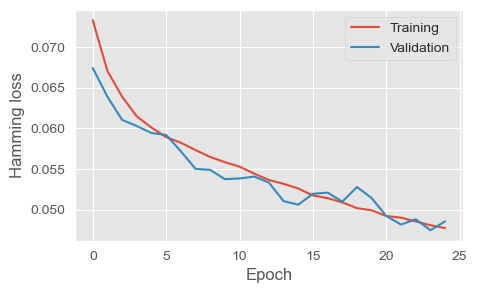

In [15]:
# Plot the hamming loss evolution
plt.figure(figsize=(5,3))
plt.plot(np.array(Ground_results['training']['hamming_loss']), label='Training')
plt.plot(np.array(Ground_results['validating']['hamming_loss']), label='Validation')
plt.legend()
plt.title('Average Hamming distance')
plt.xlabel('Epoch')
plt.ylabel("Hamming loss")
plt.savefig("GroundModel_Training_Hamming_Loss.jpg")
plt.show()

### B-iii) Saving ground model training results into a Json file

In [ ]:
import json

# create json object from dictionary
js = json.dumps(Ground_results)

# open file for writing, "w"
name = f"GroundModel_training_results_{epochs_number}epochs_{batch_size}batchsize_{learning_rate}lr_{ground_crit}_crit_{str(ground_optim).split()[0]}_optim_{date.today()}.json"
f = open(name,"a")

# write json object to file
f.write(js)

# close file
f.close()

# 6) EVALUATION

## A) Load previous models (if necessary)

In [ ]:
load_models = True

ground_model_path = 'Best_Models/groundmodel_NewClassifier_25epochs_2023-01-13.pth'
cloud_model_path = 'Best_Models/cloudmodel_NewClassifier_20epochs_2023-01-14.pth'


if load_models:
    print("Loading old models...")
    if not os.path.exists(ground_model_path):
        print('Did not find ground pretrained model file')
    if not os.path.exists(cloud_model_path):
        print('Did not find cloud pretrained model file')
    else:
        if device=="cpu":
            ground_model.load_state_dict(torch.load(f'groundmodel_NewClassifier_{date.today()}.pth', map_location=torch.device('cpu')))
            cloud_model.load_state_dict(torch.load(f'cloudmodel_NewClassifier_{date.today()}.pth', map_location=torch.device('cpu')))
        else:
            ground_model.load_state_dict(torch.load(ground_model_path))
            ground_model.to(device)
            cloud_model.load_state_dict(torch.load(cloud_model_path))
            cloud_model.to(device)
    print(".... loaded !")

In [ ]:
tags_ground = ['haze', 'primary', 'agriculture', 'water', 'habitation', 'road', 'cultivation', 'slash_burn',
         'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming',
        'selective_logging', 'blow_down']
target_ground = "ground_target"

In [ ]:
testing_results = testing_multi(test_dataloader, ground_model, cloud_model, device = device,
                                criterion_gr=nn.BCEWithLogitsLoss(), criterion_cl =nn.BCELoss())

## B) Testing the ground label's model

In [ ]:
report_ground = classification_report(y_true=testing_results['ground']['target'], 
                                      y_pred=testing_results['ground']['predicted'],
                                      target_names = test_dataloader.dataset.tags_ground.keys(),
                                      output_dict=True, zero_division=0)


In [ ]:
plt.figure(figsize = (7,5), dpi = 120)
sns.heatmap(pd.DataFrame(report_ground).iloc[:-1, :-4].T, annot=True, cmap="PiYG")
plt.savefig("./ground_testing")

In [ ]:
plt.figure()
sns.heatmap(pd.DataFrame(report_ground).iloc[:-1, -4:].T, annot=True, cmap="PiYG")

In [ ]:
plt.figure()
sns.heatmap(pd.DataFrame(report_ground).iloc[-1:, :].T, annot=True, cmap="PiYG")
plt.xlabel('the number of actual occurrences of the class in the dataset')

## C) Testing the cloud label's model

In [ ]:
report_cloud = classification_report(y_true=testing_results['cloud']['target'], 
                                      y_pred=testing_results['cloud']['predicted'],
                                      target_names = test_dataloader.dataset.tags_cloud.keys(),
                                      output_dict=True, zero_division=0)

In [ ]:
plt.figure()
sns.heatmap(pd.DataFrame(report_cloud).iloc[:-1, :-4].T, annot=True, cmap="PiYG")

In [ ]:
plt.figure()
sns.heatmap(pd.DataFrame(report_cloud).iloc[:-1, -4:].T, annot=True, cmap="PiYG")

In [ ]:
plt.figure()
sns.heatmap(pd.DataFrame(report_cloud).iloc[-1:, :].T, annot=True, cmap="PiYG")
plt.xlabel('the number of actual occurrences of the class in the dataset')

### Both Models

In [ ]:
all_tags = list(test_dataloader.dataset.tags_ground.keys()) + list(test_dataloader.dataset.tags_cloud.keys())
report_total = classification_report(y_true=testing_results['total']['target'], 
                                      y_pred=testing_results['total']['predicted'],
                                      target_names = all_tags,
                                      output_dict=True, zero_division=0)

In [ ]:
plt.figure()
sns.heatmap(pd.DataFrame(report_total).iloc[:-1, :-4].T, annot=True, cmap="PiYG")

In [ ]:
plt.figure()
sns.heatmap(pd.DataFrame(report_total).iloc[:-1, -4:].T, annot=True, cmap="PiYG")

In [ ]:
plt.figure()
sns.heatmap(pd.DataFrame(report_total).iloc[-1:, :].T, annot=True, cmap="PiYG")
plt.xlabel('the number of actual occurrences of the class in the dataset')
plt.show()